# Purpose of this simulation


In [45]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import seaborn as sns
import numpy as np
import aopy
import sklearn
from weights import *

# so that we write in latex
from matplotlib import rc
from weights_linear_regression import calc_R2_with_sim_C
# rc('font', **{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)

import numpy as np
np.set_printoptions(precision=5, suppress=True)
sns.set_context('paper')

# ideas

In [3]:


data_dump_folder = \
'/home/aolab/sijia/data/figure2_simulation_setup/'

ROUND_DECIMALS = 3


random_seed = 0
n_neurons = 128
s = 1.0

# clda setup 
rho = 0.5
batch_len = 100
feature_selection_method = "full"
encoder_change_mode = "same"
# encoder_change_mode = "change_to_zeros"

noises = [32]
fixed_noise_level = 32

# we set up the neural populations
mean_first_peak = 50
mean_second_peak = 100
std_of_peaks = 3

norm_var_2 = [mean_first_peak, mean_second_peak]
mean_second_peaks = [50, 110]

# feature_selection_method 
FEATURE_SELECTOR_TYPE = "full"
exp_conds = []


exp_conds = [f'{FEATURE_SELECTOR_TYPE}_{s}_{random_seed}_noise_{fixed_noise_level}_{n_neurons}_{mean_second_peak}_{std_of_peaks}_clda_rho_{rho}_batchlen_{batch_len}_{encoder_change_mode}'\
            for mean_second_peak in mean_second_peaks]

print(data_dump_folder)
print(exp_conds)

/home/aolab/sijia/data/figure2_simulation_setup/
['full_1.0_0_noise_32_128_50_3_clda_rho_0.5_batchlen_100_same', 'full_1.0_0_noise_32_128_110_3_clda_rho_0.5_batchlen_100_same']


In [4]:
from afs_files import load_feature_selection_files
(exp_data_all, exp_metadata_all) = load_feature_selection_files(data_dump_folder, exp_conds)
print(f'we collected {len(exp_data_all)} number of experiments')

/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:382: UserWarning: Warning: no sync clock connected! This will usually result in problems.
  warnings.warn("Warning: no sync clock connected! This will usually result in problems.")
/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:449: UserWarning: No sync events present, using bmi3d events instead
  warnings.warn("No sync events present, using bmi3d events instead")


we collected 2 number of experiments


In [5]:
feature_weights_all = [exp_data_all[i]['feature_selection']['feature_weights'] for i in range(len(exp_data_all))]

len(feature_weights_all)


2

In [6]:
# plot the histogram of the feature weights

colors = ['b', 'orange']

fig_weight, ax_weight = plt.subplots()

std = 3

bins = np.linspace(0, 150, 50)

for feature_weights, c in zip(feature_weights_all, colors):

    ax_weight.hist(feature_weights, bins, color = c, label = f'{std} Hz', alpha = 0.5 )
    ax_weight.axvline(x = 75, color = 'k')
    ax_weight.set_xlabel('Modulation depth (Hz)')
    ax_weight.set_ylabel('Counts')
    ax_weight.set_title(f'Feature distribution std {std} Hz')
    
fig_weight.show()

# Check feature selection strategies

## Plot selected features across feature selection methods

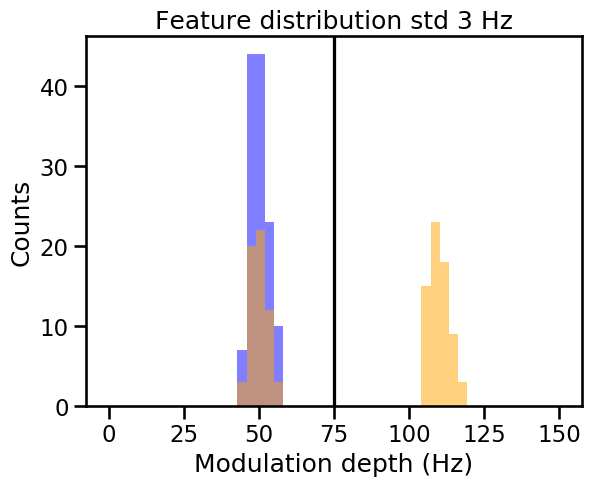

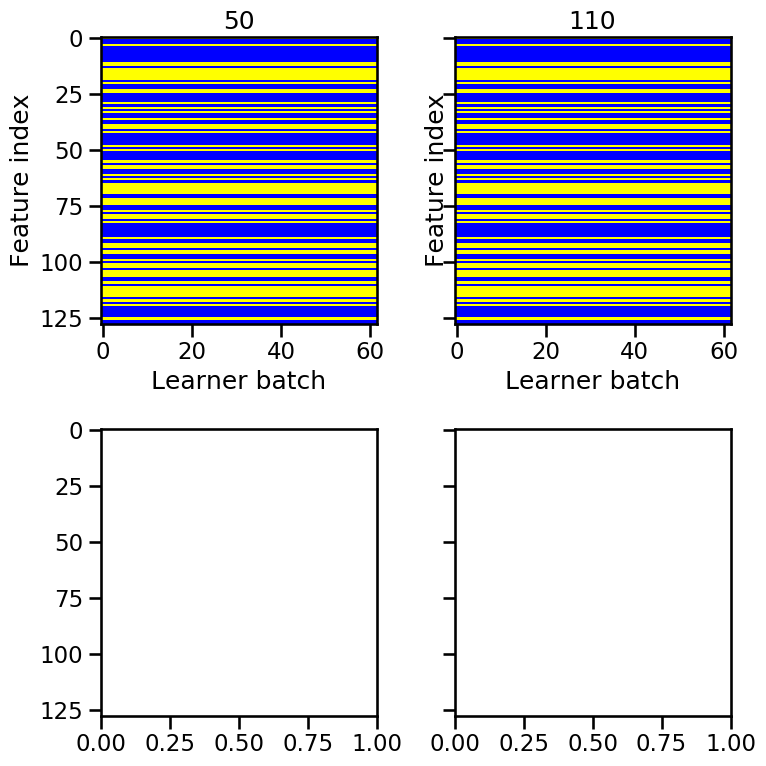

In [7]:
import importlib 
from afs_plotting import plot_feature_selection

if len(exp_data_all) ==  1:
    plot_feature_selection(exp_data_all[0]['feature_selection']['feat_set'])
else:
    
    num_columns = len(exp_data_all)

    fig_feat_activity, ax_feat_activity = plt.subplots(2, 2, 
                                                    sharey = True,
                                                    figsize = (8, 8))



    for i, (e, a) in enumerate(zip(exp_data_all,  ax_feat_activity.flatten())):
        plot_feature_selection(e['feature_selection']['feat_set'], ax = a)
        
        a.set_title(mean_second_peaks[i] )

    fig_feat_activity.tight_layout()

plt.show()


# Behaviour comparision

## count how many rewards

In [10]:
fps = 60

reward_rate_all = list()
window_time_stamps_all = list()
NUM_EXP = len(exp_data_all)

total_rewards_all = list()

for i in range(NUM_EXP):

    time_stamps = exp_data_all[i]['events']['time'] / fps
    events = exp_data_all[i]['events']['event']
    
    
    num_rewards = np.count_nonzero(events == b'REWARD')

    (reward_rate, window_time_stamps) = aopy.analysis.calc_running_event_rate(b'REWARD', events, time_stamps, 
                                                                window_size= 120,
                                                                 window_step= 30)
    
    
    reward_rate_all.append(reward_rate)
    window_time_stamps_all.append(window_time_stamps)
    total_rewards_all.append(num_rewards)
    
    # print(num_rewards, reward_rate, window_time_stamps)


window_stamps_all_gap = np.array(window_time_stamps_all)
reward_rate_all_gap = np.array(reward_rate_all) 

reward_rate_all_gap = reward_rate_all_gap.reshape((NUM_EXP,-1))
window_stamps_all_gap = window_stamps_all_gap.reshape((NUM_EXP,-1))

total_rewards_all_gap = np.array(total_rewards_all)



In [11]:
colors = ['blue', 'orange', 'red']

plt.plot( window_time_stamps, reward_rate_all_gap.T)
plt.xlabel('Time (min)')
plt.ylabel(r'Reward rate (rewards/min)')


Text(0, 0.5, 'Reward rate (rewards/min)')

## Calculate the relvance

In [18]:
R_2_over_batches_all_exp = []


X_VEL_STATE = 3
Y_VEL_STATE = 5
CONST_STATE = 6

for exp_index in range(len(exp_data_all)):
    intended_kin = exp_data_all[exp_index]['bmi3d_clda']['intended_kin']
    spike_counts_batch = exp_data_all[exp_index]['bmi3d_clda']['spike_counts_batch']
    
    intended_velocities = intended_kin[:,(X_VEL_STATE, Y_VEL_STATE, CONST_STATE), :]
    
    # get C_mat
    feature_selection_data = exp_data_all[exp_index]['feature_selection']
    C_mat = feature_selection_data["C_mat"]
    feat_set = feature_selection_data["feat_set"]
    
    # calculate R_2 over batches
    R_2_over_batches = calc_R2_with_sim_C(spike_counts_batch, intended_velocities, C_mat, feat_set, debug = False)
    
    #save  the results
    R_2_over_batches_all_exp.append(R_2_over_batches)
    
    print(exp_index)
    
R_2_over_batches_all_exp = np.array(R_2_over_batches_all_exp)
R_2_over_batches_all_exp_gap = R_2_over_batches_all_exp.T

0
1


## Plot the results

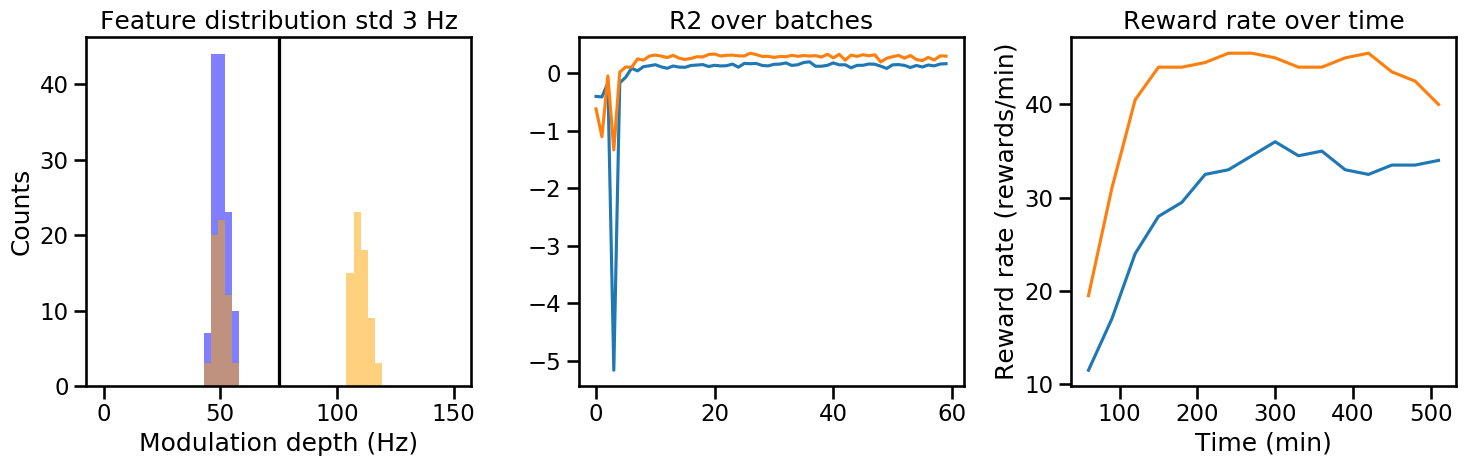

In [17]:
colors = ['b', 'orange']
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# First subplot
std = 3
bins = np.linspace(0, 150, 50)
for feature_weights, c in zip(feature_weights_all, colors):
    axs[0].hist(feature_weights, bins, color=c, label=f'{std} Hz', alpha=0.5)
    axs[0].axvline(x=75, color='k')
    axs[0].set_xlabel('Modulation depth (Hz)')
    axs[0].set_ylabel('Counts')
    axs[0].set_title(f'Feature distribution std {std} Hz')

# Second subplot
axs[1].plot(R_2_over_batches_all_exp.T)
axs[1].set_title('R2 over batches')

# Third subplot
axs[2].plot(window_time_stamps, reward_rate_all_gap.T )
axs[2].set_xlabel('Time (min)')
axs[2].set_ylabel('Reward rate (rewards/min)')
axs[2].set_title('Reward rate over time')

plt.tight_layout()
plt.show()

In [26]:
CENTER_TARGET_ON = 16
CURSOR_ENTER_CENTER_TARGET = 80
CENTER_TARGET_OFF = 32
REWARD = 48
DELAY_PENALTY = 66
TIMEOUT_PENALTY = 65
HOLD_PENALTY = 64
TRIAL_END = 239

import functools

def get_all_cursor_trajectories(exp_data_all, start_code = [20], end_codes = [REWARD, HOLD_PENALTY]):
    
    cursor_trajectories_list = list()
        
    for e in exp_data_all:
        (cursor_trajectories, trial_segments, trial_times) = get_cursor_trajectories_from_parsed_data(e, start_code = start_code, end_codes=end_codes)
        cursor_trajectories_list.append(cursor_trajectories)

    
    return cursor_trajectories_list

def get_cursor_trajectories_from_parsed_data(exp_data, start_code = [20], end_codes = [REWARD, HOLD_PENALTY]):
    
    
    events = exp_data['events']
    cursor_kinematics = exp_data['task']['cursor'][:,[0,2]] # cursor (x, z, y) position on each bmi3d cycle

    streamed_code = events['code']
    event_cycles = events['time'] # confusingly, 'time' here refers to cycle count

    trial_segments, trial_times = aopy.preproc.get_trial_segments(streamed_code, event_cycles, start_code,  end_codes)
    trial_segments = np.array(trial_segments)
    trial_indices = [range(t[0], t[1]) for t in trial_times]
    cursor_trajectories = [cursor_kinematics[t] for t in trial_indices]
    
    return (cursor_trajectories, trial_segments, trial_times)

In [27]:
start_codes = range(17, 24)
print(start_codes)

cursor_trajectories_list = get_all_cursor_trajectories(exp_data_all, start_code=start_codes)


range(17, 24)


In [28]:
def calc_trial_times(trial_times):
    """
    for each row, calculate the difference between the last and first elements
    """
    row_index = 1 
    
    return np.apply_along_axis(lambda row: row[-1] - row[0], row_index, trial_times)


#calc_trial_times(trial_times)

In [29]:
# get the unique target positions

from typing import List, Dict
import seaborn as sns


def plot_cursor_trajectories(cursor_trajectories: List, exp_data:Dict, exp_metadata,ax = None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))

    trials = exp_data['trials']
    trial_targets = aopy.postproc.get_trial_targets(trials['trial'], trials['target'][:,[0,2]]) # (x, z, y) -> (x, y)
    unique_targets = np.unique(np.concatenate(([t[1] for t in trial_targets], trial_targets[0])), axis=0)


    target_radius =  exp_metadata['target_radius']
    bounds = [-11, 11, -11, 11]
    
    sns.color_palette("dark:salmon_r", as_cmap=True)

    aopy.visualization.plot_trajectories(cursor_trajectories, bounds = bounds, ax = ax)
    aopy.visualization.plot_targets(unique_targets, target_radius, ax = ax)

# Analyze the encoder shuffle result

In [19]:


data_dump_folder = \
'/home/aolab/sijia/data/figure2_simulation_setup/'

ROUND_DECIMALS = 3


random_seed = 0
n_neurons = 128
s = 1.0

# clda setup 
rho = 0.5
batch_len = 100
feature_selection_method = "full"
encoder_change_mode = "swap_top_and_bottom"

noises = [32]
fixed_noise_level = 32

# we set up the neural populations
mean_first_peak = 50
mean_second_peak = 110
std_of_peaks = 3

norm_var_2 = [mean_first_peak, mean_second_peak]

# feature_selection_method 
FEATURE_SELECTOR_TYPE = "full"
init_feat_first_or_last_all = ['first', "last"]
exp_conds = []


exp_conds = [f'{FEATURE_SELECTOR_TYPE}_{s}_{random_seed}_noise_{fixed_noise_level}_{n_neurons}_{mean_second_peak}_{std_of_peaks}_clda_rho_{rho}_batchlen_{batch_len}_init_{init_feat}_{encoder_change_mode}'\
            for init_feat in init_feat_first_or_last_all]

print(data_dump_folder)
for e in exp_conds:print(e)

/home/aolab/sijia/data/figure2_simulation_setup/
full_1.0_0_noise_32_128_110_3_clda_rho_0.5_batchlen_100_init_first_swap_top_and_bottom
full_1.0_0_noise_32_128_110_3_clda_rho_0.5_batchlen_100_init_last_swap_top_and_bottom


In [20]:
(exp_data_all, exp_metadata_all) = load_feature_selection_files(data_dump_folder, exp_conds)

print(f'we collected {len(exp_data_all)} number of experiments')

/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:382: UserWarning: Warning: no sync clock connected! This will usually result in problems.
  warnings.warn("Warning: no sync clock connected! This will usually result in problems.")
/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:449: UserWarning: No sync events present, using bmi3d events instead
  warnings.warn("No sync events present, using bmi3d events instead")


we collected 2 number of experiments


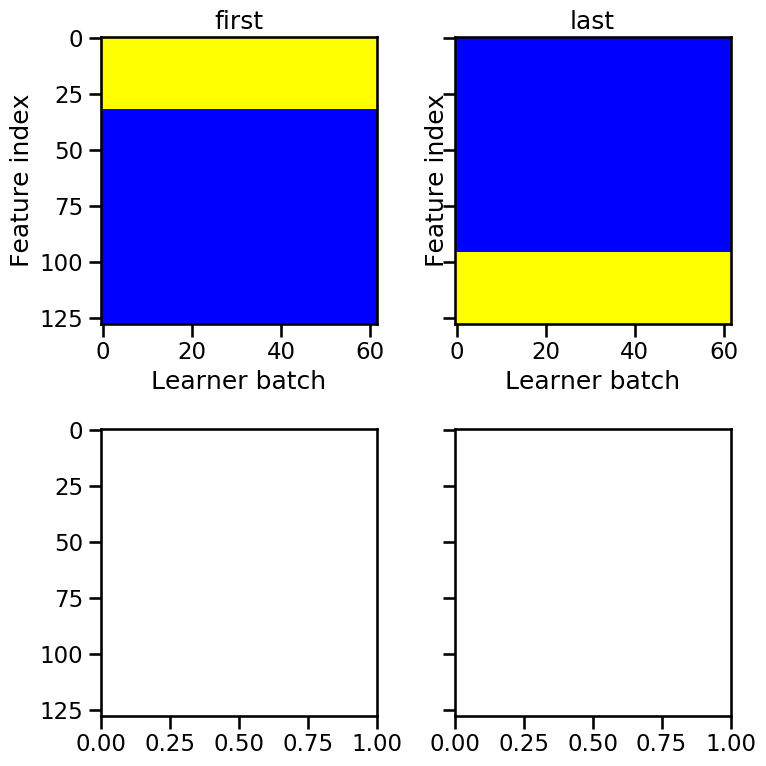

In [21]:
import importlib 
from afs_plotting import plot_feature_selection

if len(exp_data_all) ==  1:
    plot_feature_selection(exp_data_all[0]['feature_selection']['feat_set'])
else:
    
    num_columns = len(exp_data_all)

    fig_feat_activity, ax_feat_activity = plt.subplots(2, 2, 
                                                    sharey = True,
                                                    figsize = (8, 8))



    for i, (e, a) in enumerate(zip(exp_data_all,  ax_feat_activity.flatten())):
        plot_feature_selection(e['feature_selection']['feat_set'], ax = a)
        
        a.set_title(init_feat_first_or_last_all[i])

    fig_feat_activity.tight_layout()

plt.show()

In [22]:
threshold = 90

feature_weights = exp_data_all[0]['feature_selection']['feature_weights']
exp_data_all[0]['feature_selection'].keys()
new_sim_c = exp_data_all[0]['feature_selection']['new_sim_c']
sim_c = exp_data_all[0]['feature_selection']['sim_C']

good_features_initial = (np.linalg.norm(sim_c, axis=1) >threshold)
good_features_after_shuffled = (np.linalg.norm(new_sim_c, axis=1) >threshold)


nnum_of_repeats_before,  num_of_repeats_after= 30, 30


old_features_before_shuffled_repeat = np.repeat(good_features_initial[:, np.newaxis],
                                                nnum_of_repeats_before, axis = 1)
new_features_after_shuffled_repeat = np.repeat(good_features_after_shuffled[:, np.newaxis],
                                                num_of_repeats_after, axis = 1)

encoder_weight_change = np.concatenate((old_features_before_shuffled_repeat,
                                        new_features_after_shuffled_repeat), axis = 1)

encoder_weight_change.shape

(128, 60)

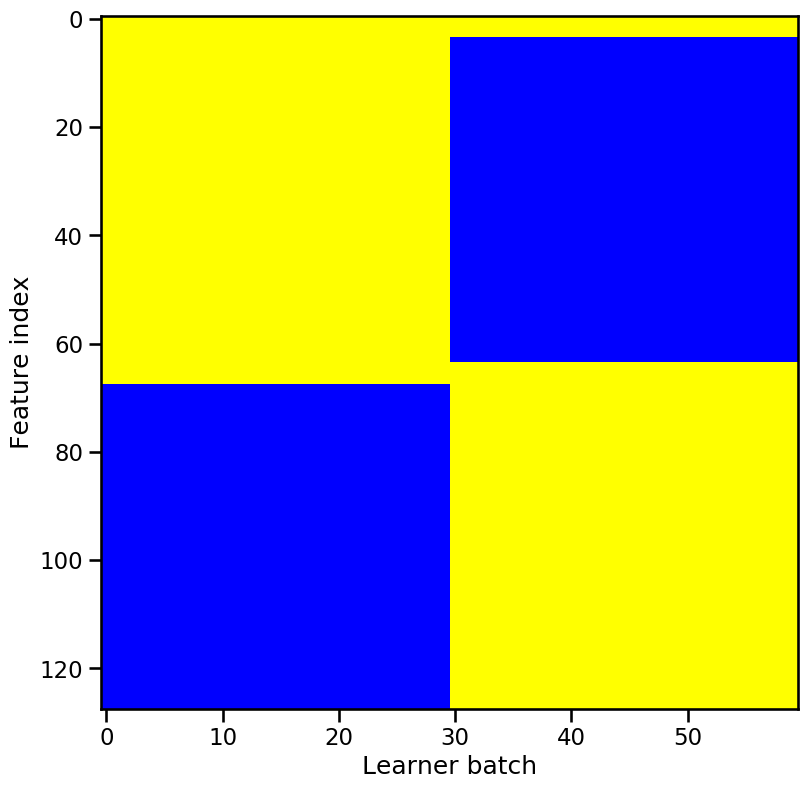

In [23]:
summary_figure, summary_axes = plt.subplots(figsize = (9, 9))
plot_feature_selection(encoder_weight_change.T, ax = summary_axes)
summary_figure

In [24]:
fps = 60

reward_rate_all = list()
window_time_stamps_all = list()
NUM_EXP = len(exp_data_all)

total_rewards_all = list()

for i in range(len(exp_data_all)):

    time_stamps = exp_data_all[i]['events']['time'] / fps
    events = exp_data_all[i]['events']['event']
    
    
    num_rewards = np.count_nonzero(events == b'REWARD')

    (reward_rate, window_time_stamps) = aopy.analysis.calc_running_event_rate(b'REWARD', events, time_stamps, 
                                                                window_size= 120,
                                                                 window_step= 30)
    
    window_time_stamps = window_time_stamps / fps
    
    reward_rate_all.append(reward_rate )
    window_time_stamps_all.append(window_time_stamps)
    total_rewards_all.append(num_rewards)
    
    # print(num_rewards, reward_rate, window_time_stamps)


window_stamps_all = np.array(window_time_stamps_all)
reward_rate_all = np.array(reward_rate_all) 

reward_rate_all = reward_rate_all.reshape((NUM_EXP,-1))
window_stamps_all = window_stamps_all.reshape((NUM_EXP,-1))

total_rewards_all = np.array(total_rewards_all)

## let's calculate the relevance

In [26]:
R_2_over_batches_all_exp = []


X_VEL_STATE = 3
Y_VEL_STATE = 5
CONST_STATE = 6

for exp_index in range(len(exp_data_all)):
    intended_kin = exp_data_all[exp_index]['bmi3d_clda']['intended_kin']
    spike_counts_batch = exp_data_all[exp_index]['bmi3d_clda']['spike_counts_batch']
    
    intended_velocities = intended_kin[:,(X_VEL_STATE, Y_VEL_STATE, CONST_STATE), :]
    
    # get C_mat
    feature_selection_data = exp_data_all[exp_index]['feature_selection']
    C_mat = feature_selection_data["C_mat"]
    feat_set = feature_selection_data["feat_set"]
    
    # calculate R_2 over batches
    R_2_over_batches = calc_R2_with_sim_C(spike_counts_batch, intended_velocities, C_mat, feat_set, debug = False)
    
    #save  the results
    R_2_over_batches_all_exp.append(R_2_over_batches)
    
    print(exp_index)
    
R_2_over_batches_all_exp = np.array(R_2_over_batches_all_exp)
R_2_over_batches_all_exp_shuffle = R_2_over_batches_all_exp.T

0
1


# Make a summary figure

/tmp/ipykernel_197820/3548828327.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_full, axes_full = plt.subplots(2, 3, figsize=(6.5, 4))


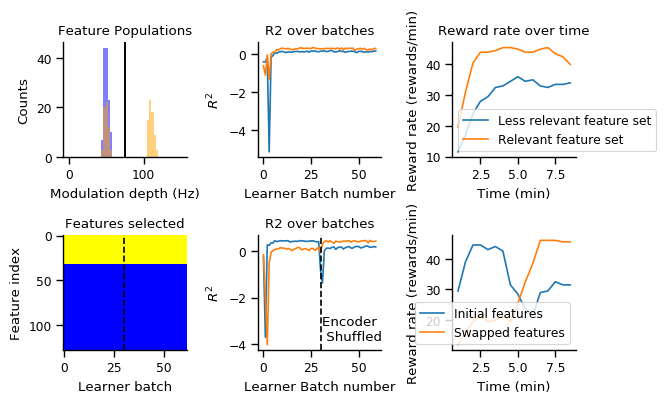

In [59]:
FEATURE_SHUFFLING_TIME = 30
# make a summary figure


colors = ['b', 'orange']
fig_full, axes_full = plt.subplots(2, 3, figsize=(6.5, 4))

# First subplot
std = 3

axs = axes_full[0,:]

bins = np.linspace(0, 150, 50)
for feature_weights, c in zip(feature_weights_all, colors):
    axs[0].hist(feature_weights, bins, color=c, label=f'{std} Hz', alpha=0.5)
    axs[0].axvline(x=75, color='k')
    axs[0].set_xlabel('Modulation depth (Hz)')
    axs[0].set_ylabel('Counts')
    axs[0].set_title(f'Feature Populations')

# Second subplot
axs[1].plot(R_2_over_batches_all_exp_gap)
axs[1].set_title('R2 over batches')
axs[1].set_xlabel('Learner Batch number')
axs[1].set_ylabel(r'$R^2$')

# Second subplot
axs[2].plot(window_time_stamps, reward_rate_all_gap.T )  
axs[2].set_xlabel('Time (min)')
axs[2].set_ylabel('Reward rate (rewards/min)')
axs[2].legend([ 'Less relevant feature set', 'Relevant feature set'])
axs[2].set_title('Reward rate over time')
# second row, we show the plots for the shuffled rows

axs = axes_full[1,:]
plot_feature_selection(exp_data_all[0]['feature_selection']['feat_set'], ax = axs[0])
axs[0].set_title('Features selected')
axs[0].axvline(x = 30, color = 'k', linestyle='--')


# Second subplot
axs[1].plot(R_2_over_batches_all_exp_shuffle)
axs[1].set_title('R2 over batches')
axs[1].set_xlabel('Learner Batch number')
axs[1].axvline(x = 30, color = 'k', linestyle='--')
axs[1].text(30.5, 0.3, 'Encoder \n Shuffled', ha='left', va='top', transform=axs[1].get_xaxis_transform())
axs[1].set_ylabel(r'$R^2$')

axs[2].plot( window_time_stamps, reward_rate_all.T)
axs[2].set_xlabel('Time (min)')
axs[2].set_ylabel(r'Reward rate (rewards/min)')
axs[2].legend(['Initial features', 'Swapped features'], loc = 'lower right')

sns.despine()

fig_full.tight_layout()
fig_full

In [60]:
fig_full.savefig('/home/aolab/sijia/adaptive_feature_selection/figure2_simulation_setup/figure2_full_feature_selection.pdf', dpi = 300)